### Підготовка середовища

In [1]:
%pip install opencv-python scikit-image scikit-learn pandas tensorflow keras tqdm

#### Імпорт бібліотек

In [20]:
import os
from PIL import Image

**DataLeakage (Аналіз)**
1. Аналіз самих даних та можливі витоки:
- Скоріше за все датасет збирали різні люди, так як формати і дані досить сильно можуть відрізнятись (як результат потрібно окремо просіювати датасет, в нашому випадку робимо ми це вручну, переглядаючи картинки)
- Забрудення даних (точно виявлено картинка для класу, яка взагалі не відноситься до теми + є картинки з текстом, це не добре для моделі в цілому тому, знову ж таки потрібно відбирати картинки вручну або задіювати активне машинне навчання)
- Чи є дублікати? (перевіряємо на дублікати зображення, щоб не було так, що ніби різні картинки, хоча вони можуть бути ідентичні, потрапили в різні вибірки)

Налаштування шляху до необробленого датасету

In [ ]:
dataset_path = "datasets/house_plant_species"

Огляд всіх можливих класів (ознайомлення з датасетом)

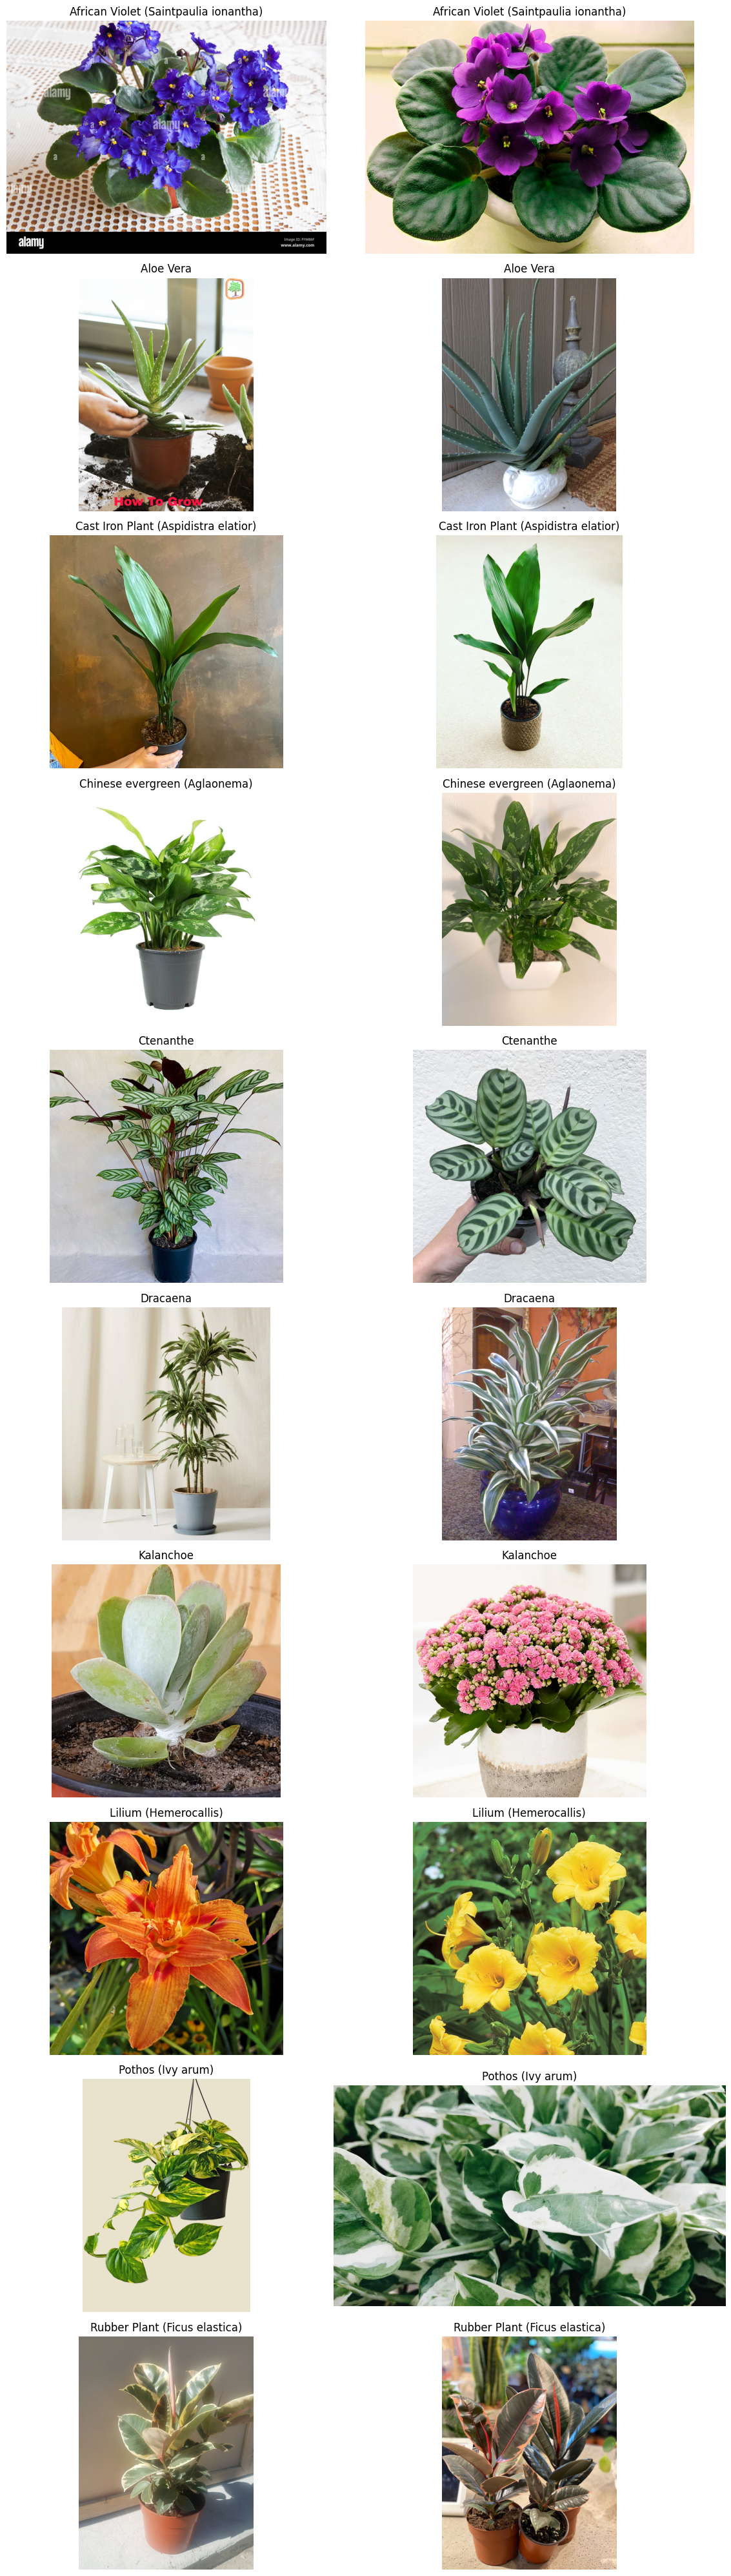

In [ ]:
classes = os.listdir(dataset_path)

num_images_per_class = 2
num_classes = len(classes)

plt.figure(figsize=(12, num_classes * 4))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    images = os.listdir(class_folder)


    for j in range(min(num_images_per_class, len(images))):
        img_path = os.path.join(class_folder, images[j])
        img = Image.open(img_path)

        plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)

plt.tight_layout()
plt.show()

Код для реалізації перевірки дублікатів шляхом хешування або коефіцієнта подібності

In [ ]:
import os
import hashlib
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

class ImageDuplicateFinder:
    def __init__(self, threshold=0.95):
        """
        Ініціалізація класу для пошуку дублікатів зображень.

        :param threshold: Поріг подібності зображень (0-1).
        """
        self.threshold = threshold

    def _hash_image(self, image_path):
        """
        Генерація хешу зображення (MD5).

        :param image_path: Шлях до зображення.
        :return: Хеш зображення.
        """
        try:
            with open(image_path, 'rb') as f:
                return hashlib.md5(f.read()).hexdigest()
        except Exception:
            return None

    def _perceptual_hash(self, image_path, hash_size=8):
        """
        Перцептивний хеш зображення.

        :param image_path: Шлях до зображення.
        :param hash_size: Розмір хешу.
        :return: Перцептивний хеш.
        """
        try:
            img = Image.open(image_path).convert('L')
            img = img.resize((hash_size + 1, hash_size + 1), Image.LANCZOS)
            pixels = np.array(img)
            avg = pixels.mean()
            diff = pixels > avg
            return sum([2**i for (i, v) in enumerate(diff.flatten()) if v])
        except Exception:
            return None

    def _compare_images(self, image1_path, image2_path):
        """
        Порівняння двох зображень за подібністю.

        :param image1_path: Шлях до першого зображення.
        :param image2_path: Шлях до другого зображення.
        :return: Коефіцієнт подібності (0-1).
        """
        try:
            img1 = cv2.imread(image1_path)
            img2 = cv2.imread(image2_path)
            img1 = cv2.resize(img1, (256, 256))
            img2 = cv2.resize(img2, (256, 256))
            gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            similarity = cv2.matchTemplate(gray1, gray2, cv2.TM_CCOEFF_NORMED)
            return similarity.max()
        except Exception:
            return 0

    def find_duplicates(self, directory, method='hash'):
        """
        Пошук дублікатів зображень.

        :param directory: Директорія з зображеннями.
        :param method: Метод пошуку ('hash', 'perceptual', 'compare').
        :return: Словник дублікатів.
        """
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
        image_paths = []
        for root, _, files in os.walk(directory):
            for file in files:
                if os.path.splitext(file)[1].lower() in image_extensions:
                    image_paths.append(os.path.join(root, file))

        duplicates = {}

        if method == 'hash':
            compare_func = self._hash_image
        elif method == 'perceptual':
            compare_func = self._perceptual_hash
        else:
            compare_func = self._compare_images

        hashes = {}
        with ProcessPoolExecutor() as executor:
            futures = {
                executor.submit(compare_func, path): path
                for path in image_paths
            }
            for future in tqdm(as_completed(futures), total=len(futures)):
                path = futures[future]
                try:
                    hash_value = future.result()
                    if hash_value in hashes:
                        if path not in duplicates:
                            duplicates[path] = []
                        duplicates[path].append(hashes[hash_value])
                    else:
                        hashes[hash_value] = path
                except Exception:
                    pass

        return duplicates

    def remove_duplicates(self, duplicates, keep_first=True):
        """
        Видалення дублікатів.

        :param duplicates: Словник дублікатів.
        :param keep_first: Залишати перше зображення.
        """
        for original, duplicate_list in duplicates.items():
            for duplicate in duplicate_list:
                try:
                    os.remove(duplicate)
                    print(f"Видалено дублікат: {duplicate}")
                except Exception as e:
                    print(f"Помилка видалення {duplicate}: {e}")


Шукаємо дублікати

In [ ]:
finder = ImageDuplicateFinder(threshold=0.95)

duplicates = finder.find_duplicates(dataset_path, method='perceptual')

for original, duplicate_files in duplicates.items():
    print(f"Оригінал: {original}")
    for duplicate in duplicate_files:
        print(f"  - Схоже/дублікат: {duplicate}")

Якщо потрібно видаляємо дублікати

In [ ]:
finder.remove_duplicates(duplicates)

**DataLeakage**

Переходимо до розбиття даних:
1. Розбиття має відбувати не рандомно, а враховуючи структуру даних + ми маємо розділяти дані на тренувальну, тестову, валідаційну вибірки до них мають потрапити абсолютно різні фото, потрібно виключити попадання схожих зображень до різних наборів. Це ми можемо зробити шляхом ручного розбиття, так щоб наприклад ті що вже входять у вибірку валідаційну або текстову зі 100% не могли потрапити в тренувальну. В нашому випадку написали функцію split_dataset для цього.

2. Нормалізація має відбуватись по кожному наборі, тобто для тренувальних, тестових, валідаційних даних окремо. (в даному випадку нормалізація буде завжди однокова, мінімальний та максимальний піксель 1-255, більше чи менше просто бути не може, але це тільки для зображень)

3. Для виключення помилок в коді і просто проблем з точки зору програміста-аналітика, обов'язково вводимо pipeline

4. Датасет не має містити службової інформації та метаданих (в ношому випадку - це зображення і label класу, тому цієї інформації немає)

5. Щодо ознак в даному випадку пікселі без інших даних, тому потрапити дані з цільовї змінної туда не могли

  Розподіл датасету на train/val/test + pool з унеможливленням перетину даних

In [ ]:
import os
import shutil
import random

def split_dataset(
    source_dir,
    output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_seed=42
):
    """
    Розподіл датасету на train/val/test з унеможливленням перетину даних

    :param source_dir: шлях до вихідної директорії з класами
    :param output_dir: шлях до нової директорії для розподіленого датасету
    :param train_ratio: частка тренувальних даних
    :param val_ratio: частка валідаційних даних
    :param test_ratio: частка тестових даних
    :param random_seed: seed для відтворюваності
    """
    random.seed(random_seed)

    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-10:
        raise ValueError("Суми часток мають дорівнювати 1.0")

    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'validation')
    test_dir = os.path.join(output_dir, 'test')
    pool_dir = os.path.join(output_dir, 'pool')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(pool_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)

        if not os.path.isdir(class_path):
            continue

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        files = os.listdir(class_path)

        random.shuffle(files)

        total_files = len(files)
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count

        train_files = files[:train_count]
        val_files = files[train_count:train_count+val_count]
        test_files = files[train_count+val_count:]

        for file_list, dest_dir in [
            (train_files, os.path.join(train_dir, class_name)),
            (val_files, os.path.join(val_dir, class_name)),
            (test_files, os.path.join(test_dir, class_name))
        ]:
            for filename in file_list:
                src_path = os.path.join(class_path, filename)
                dst_path = os.path.join(dest_dir, filename)
                shutil.move(src_path, dst_path)


        if not os.listdir(class_path):
            os.rmdir(class_path)

    if not os.listdir(source_dir):
        os.rmdir(source_dir)

    print(f"Датасет розподілено в {output_dir}")

Використовуємо функцію розподілу

In [ ]:
split_dataset(
    source_dir='datasets/house_plant_species',
    output_dir='datasets/data_store',
)

Датасет розподілено в datasets/data_store


### **Створємо модель**

Загальні імпорти

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop

Загальні налаштування

In [4]:
img_height = 224
img_width = 224
batch_size = 84

Створюємо генератори та шляхи до даних

In [ ]:
train_data_path = "datasets/data_store/train"
validationn_data_path = "datasets/data_store/validation"
test_data_path = "datasets/data_store/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
    )
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

Застосовуємо генератори з окремою нормалізацією та даними, які не перетинаються

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    validationn_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2163 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 474 images belonging to 10 classes.


Задаємо кількість класів

In [7]:
num_classes = 10

In [ ]:
class_indices = train_generator.class_indices

indices_to_labels = {v: k for k, v in class_indices.items()}

print("Class indices:", class_indices)
print("Indices to labels:", indices_to_labels)

Class indices: {'African Violet (Saintpaulia ionantha)': 0, 'Aloe Vera': 1, 'Cast Iron Plant (Aspidistra elatior)': 2, 'Chinese evergreen (Aglaonema)': 3, 'Ctenanthe': 4, 'Dracaena': 5, 'Kalanchoe': 6, 'Lilium (Hemerocallis)': 7, 'Pothos (Ivy arum)': 8, 'Rubber Plant (Ficus elastica)': 9}
Indices to labels: {0: 'African Violet (Saintpaulia ionantha)', 1: 'Aloe Vera', 2: 'Cast Iron Plant (Aspidistra elatior)', 3: 'Chinese evergreen (Aglaonema)', 4: 'Ctenanthe', 5: 'Dracaena', 6: 'Kalanchoe', 7: 'Lilium (Hemerocallis)', 8: 'Pothos (Ivy arum)', 9: 'Rubber Plant (Ficus elastica)'}


Створення моделі та її компіляція (вирішено поки не використовувати)

In [ ]:
efficient_net_model = EfficientNetB0(
                weights="imagenet",
                include_top=False,
                input_shape = (img_height, img_width, 3)
                  )


16705208/16705208 [==============================] - 0s 0us/step


Розморожуємо модель для навчання (вирішено поки не використовувати)

In [ ]:
efficient_net_model.trainable = False

Показ архітектури моделі (вирішено поки не використовувати)

In [ ]:
efficient_net_model.summary()

Старий варіант моделі (вирішено поки не використовувати)

In [ ]:
model = Sequential()

model.add(efficient_net_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

Модель

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

None


Навчання моделі

In [9]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size = batch_size,
    epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 1070s 34s/step - accuracy: 0.1700 - loss: 3.5047 - val_accuracy: 0.2935 - val_loss: 1.9665
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.3176 - loss: 1.9143 - val_accuracy: 0.3630 - val_loss: 1.7415
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.3391 - loss: 1.8193 - val_accuracy: 0.3804 - val_loss: 1.6778
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.3864 - loss: 1.6930 - val_accuracy: 0.4239 - val_loss: 1.6126
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.4061 - loss: 1.6595 - val_accuracy: 0.4043 - val_loss: 1.6219
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.4135 - loss: 1.6040 - val_accuracy: 0.4652 - val_loss: 1.5404
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.4536 - loss: 1.5432 - val_accuracy: 0.5217 - val_loss: 1.4101
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.4464 - loss: 1.5172 - val_accuracy: 0.5326 - val_loss: 1

Візуалізація результатів навчання

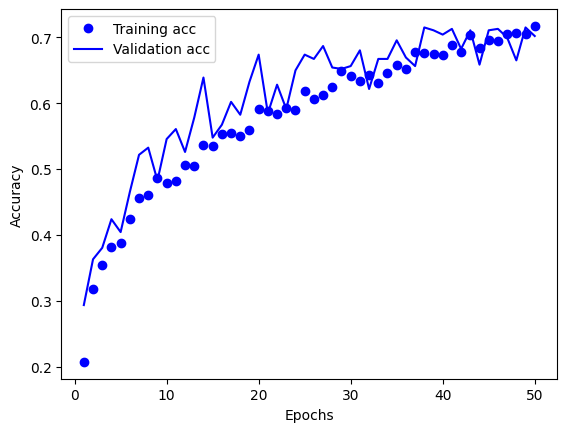

In [10]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

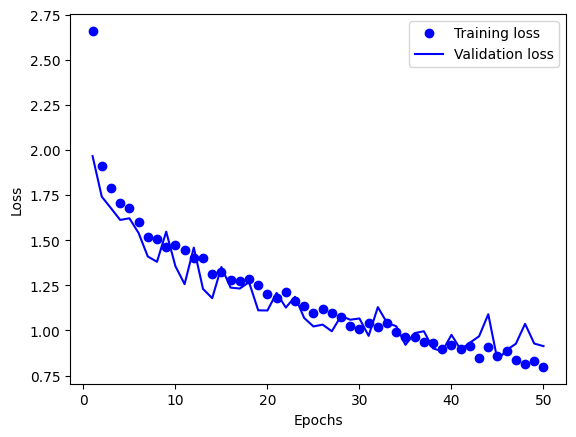

In [11]:
history_dict = history.history
acc_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Тестування на тестових даних

In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"Точність на тестових даних: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 248s 49s/step - accuracy: 0.7320 - loss: 0.8780
Точність на тестових даних: 0.7067510485649109


Збереження моделі

In [13]:
model.save('plants47_model.keras')

Використовуємо квантизацію (для зменшення розміру моделі, наприклад, для використання на телефоні)

In [ ]:
model = tf.keras.models.load_model('plants47_model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpp5zsebv_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137546698843312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546698842608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546532851552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546532856480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546532863520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546532852432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546533004112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546533004992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546533009040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137546533009744: TensorSpec(shape=(), dtype=tf.resource, name=None)


Зображення яке ми використаємо для перевірки моделі (взято з інтернету)

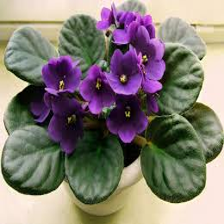

In [19]:
Image.open("test_image.jpg").resize((224, 224))

In [18]:
interpreter = tf.lite.Interpreter(model_path="model_quantized.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image = Image.open("test_image.jpg").resize((224, 224))
input_data = np.expand_dims(image, axis=0)
input_data = np.array(input_data, dtype=np.float32)
input_data = input_data / 255.0

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print("Результати передбачення:", output_data)

Результати передбачення: [[1.0000000e+00 4.8265826e-15 2.4628427e-10 7.3065526e-11 6.8144745e-10
  4.4417223e-13 2.9910203e-09 3.0181397e-08 8.7465712e-10 7.1036549e-15]]


Як бачимо 100% віддано першому класу, так і є - це перший клас "African Violet (Saintpaulia ionantha)"

### **Pipeline**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop

class PlantClassificationPipeline:
    def __init__(
        self,
        img_height=224,
        img_width=224,
        batch_size=32,
        num_classes=10
    ):
        # Параметри
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Шляхи до даних
        self.train_data_path = "datasets/data_store/train"
        self.validation_data_path = "datasets/data_store/validation"
        self.test_data_path = "datasets/data_store/test"

        # Підготовка генераторів даних
        self._prepare_data_generators()

        # Створення моделі
        self.model = self._build_model()

    def _prepare_data_generators(self):
        """Підготовка генераторів для train, validation, test"""
        # Аугментація та нормалізація
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            fill_mode='nearest'
            )
        test_datagen = ImageDataGenerator(rescale=1./255)
        valid_datagen = ImageDataGenerator(rescale=1./255)

        # Генератори
        self.train_generator = train_datagen.flow_from_directory(
            self.train_data_path,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='categorical'
        )

        self.validation_generator = valid_datagen.flow_from_directory(
            self.validation_data_path,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )

        self.test_generator =  test_datagen.flow_from_directory(
            self.test_data_path,
            target_size=(self.img_height, self.img_width),
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )

    def _build_model(self):
        """Створення архітектури нейронної мережі"""
        model = Sequential()

        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(self.img_height, self.img_width, 3)))
        model.add(MaxPooling2D())
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D())
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.num_classes, activation="softmax"))

        # Компіляція моделі
        model.compile(
            optimizer=Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def _get_callbacks(self):
        """Створення колбеків"""
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        model_checkpoint = ModelCheckpoint(
            'plant_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.00001
        )

        return [early_stopping, model_checkpoint, reduce_lr]

    def train(self, epochs=10):
        """Тренування моделі"""
        history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            batch_size = self.batch_size,
            epochs=epochs,
            callbacks=self._get_callbacks()
        )

        return history

    def evaluate(self):
        """Оцінка на тестовому наборі"""
        test_loss, test_accuracy = self.model.evaluate(
            self.test_generator
        )

        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")

        return test_loss, test_accuracy

    def predict(self, images):
        """Передбачення для нових зображень"""
        predictions = self.model.predict(images)
        return predictions

Використовуємо pipeline

In [16]:
pipeline = PlantClassificationPipeline(
        img_height=224,
        img_width=225,
        batch_size=32,
        num_classes=10
    )

history = pipeline.train(epochs=1)

pipeline.evaluate()

Found 2163 images belonging to 10 classes.
Found 460 images belonging to 10 classes.
Found 474 images belonging to 10 classes.


d:\Labs\BigData\venvGlobal\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 4/68 ━━━━━━━━━━━━━━━━━━━━ 3:03 3s/step - accuracy: 0.0918 - loss: 4.5617

d:\Labs\BigData\venvGlobal\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.1773 - loss: 2.7063 - val_accuracy: 0.3109 - val_loss: 1.8415 - learning_rate: 0.0010
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - accuracy: 0.4230 - loss: 1.7446
Test Loss: 1.8412247896194458
Test Accuracy: 0.3333333432674408


(1.8412247896194458, 0.3333333432674408)

### Альтернативний варіант представлення даних для простіших моделей

Перетворення датасету в Dataframe і його тестування на простих моделях

In [ ]:
import pandas as pd

In [ ]:
def load_and_preprocess_image(img_path, target_size=(32, 32)):
    try:
        # Відкриття зображення з явним перетворенням у RGB
        with Image.open(img_path) as img:
            img = img.convert('RGB')  # Явне перетворення у RGB
            img = img.resize(target_size, Image.LANCZOS)  # Висока якість ресайзу
            return np.array(img).flatten()
    except Exception as e:
        print(f"Помилка обробки зображення {img_path}: {e}")
        return None

In [ ]:
dataset_path = 'data/house_plant_species'

data = []
labels = []

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, image_name)

            # Перевірка розширення файлу
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                processed_image = load_and_preprocess_image(img_path)

                if processed_image is not None:
                    # Додавання масиву зображення та мітки класу
                    data.append(list(processed_image))
                    labels.append(class_name)

In [ ]:
pixel_columns = [f'pixel_{i}' for i in range(len(data[0]))]
df = pd.DataFrame(data, columns=pixel_columns)
df['class_name'] = labels

print("Форма DataFrame:", df.shape)
print("Унікальні класи:", df['class_name'].unique())
print("Перші 5 рядків:\n", df.head())

Форма DataFrame: (582, 3073)
Унікальні класи: ['African Violet (Saintpaulia ionantha)' 'Aloe Vera']
Перші 5 рядків:
    pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      236      234      234      235      234      233      233      231   
1      252      232      205      252      231      204      252      230   
2      206      214      157      201      207      146      199      203   
3      251      251      252      252      252      252      253      253   
4      224      177      149      226      173      144      229      172   

   pixel_8  pixel_9  ...  pixel_3063  pixel_3064  pixel_3065  pixel_3066  \
0      230      235  ...          18          18          18          12   
1      200      252  ...         254         234         222         253   
2      137      195  ...         193         196         146         194   
3      253      253  ...         255         255         255         255   
4      143      229  ...         247    

In [ ]:
df.to_csv("data/two_types_plants.csv", index=False)

In [ ]:
df.head()

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      236      234      234      235      234      233      233      231   
1      252      232      205      252      231      204      252      230   
2      206      214      157      201      207      146      199      203   
3      251      251      252      252      252      252      253      253   
4      224      177      149      226      173      144      229      172   

   pixel_8  pixel_9  ...  pixel_3063  pixel_3064  pixel_3065  pixel_3066  \
0      230      235  ...          18          18          18          12   
1      200      252  ...         254         234         222         253   
2      137      195  ...         193         196         146         194   
3      253      253  ...         255         255         255         255   
4      143      229  ...         247         228         214         246   

   pixel_3067  pixel_3068  pixel_3069  pixel_3070  pixel_3071  \
0          12          12           2           2           2   
1         234         220         253         234         221   
2         198         148         196         199         149   
3         255         255         255         255         255   
4         227         212         245         224         211   

                              class_name  
0  African Violet (Saintpaulia ionantha)  
1  African Violet (Saintpaulia ionantha)  
2  African Violet (Saintpaulia ionantha)  
3  African Violet (Saintpaulia ionantha)  
4  African Violet (Saintpaulia ionantha)  

[5 rows x 3073 columns]

In [ ]:
def array_to_image(pixel_array):
    # Перетворення назад у форму (32, 32, 3)
    img_array = pixel_array.reshape((32, 32, 3))
    return Image.fromarray(img_array.astype('uint8'))

first_image_row = df.iloc[0]

first_image_pixels = first_image_row.drop('class_name').values

first_image_pixels = np.array(first_image_pixels)

first_image = array_to_image(first_image_pixels)

In [ ]:
first_image_pixels

array([236, 234, 234, ..., 2, 2, 2], dtype=object)

In [ ]:
image = array_to_image(first_image_pixels)
image.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
X = df.drop('class_name', axis=1)
y = df['class_name']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(
    n_estimators=100,  # кількість дерев
    random_state=42,   # для відтворюваності
    n_jobs=-1          # використання всіх ядер процесора
)

In [ ]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print("Детальні метрики:")
print(f"Accuracy:   {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")

Детальні метрики:
Accuracy:   0.8889
Precision: 0.8901
Recall:    0.8889
F1-Score:  0.8878
